<a href="https://colab.research.google.com/github/GabrieleCalarota/ImageCaptioning/blob/master/Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
!{sys.executable} -m pip install pillow
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install tensorflow
!{sys.executable} -m pip install keras
!{sys.executable} -m pip install -q tqdm
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install pydot
!{sys.executable} -m pip install pydot-ng
!{sys.executable} -m pip install graphviz
!{sys.executable} -m pip install pydotplus
!{sys.executable} -m pip install knockknock
!{sys.executable} -m pip install keyring

  Using cached tensorflow_estimator-2.3.0-py2.py3-none-any.whl (459 kB)
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.2.0
    Can't uninstall 'tensorflow-estimator'. No files were found to uninstall.


In [2]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
from tqdm import tqdm
from knockknock import telegram_sender

In [3]:
# root_path = os.getcwd()
# annotation_file = root_path + "\\annotations_trainval2014\\annotations\\captions_train2014.json"
# PATH = root_path + "\\train2014\\train2014\\"

In [4]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
  # annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)
annotation_file = os.path.abspath('.')+'/annotations/captions_train2014.json'

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

In [5]:

# Read the json file
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Store captions and image names in vectors
all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)

    all_img_name_vector.append(full_coco_image_path)
    all_captions.append(caption)

# Shuffle captions and image_names together
# Set a random state
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)

# Select the first 80000*5 captions from the shuffled set
# num_examples = 80000
# train_captions = train_captions[:num_examples]
# img_name_vector = img_name_vector[:num_examples]

In [6]:
len(train_captions), len(img_name_vector)


(414113, 414113)

In [7]:
# inizializzo un'istanza del modelo InceptionV3 trainato su imagenet (classificazione immagini)
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
     
# l'input del mio modello è uguale all'input di InceptionV 3                                            
new_input = image_model.input
# l'output del mio modelllo è uguale all'ultimo layer di InceptionV3, una convnet con attenzione
hidden_layer=image_model.layers[-1].output

# creo il mio modello
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [8]:
#funzione per il preprocessing delle immagini in modo che siano coerenti con
#l'input di InceptionV3
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.adjust_jpeg_quality(img, jpeg_quality=10)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

#funzione per mostrare il preprocessing fatto su un'immagine e quella originale
def visualize(im_path, imAgmented, operation):
    temp_image = np.array(Image.open(im_path))
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(temp_image)
    plt.subplot(1,2,2)
    plt.title(operation)
    plt.imshow(imAgmented)

#cropped, path = load_image("E:\\Python\\Img_Caption\\COCO\\train2014\\COCO_train2014_000000000009.jpg")
# print(path)
# Image.open(path)
#visualize(path, cropped, "cropped 90%")

In [9]:
# Get unique images
# creo un set di immagini sortate e uniche
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
# creo il dataset di immagini
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)

# applico la funzione di preprocessing su tutte le immagini del dataset
# tf.data.experimental.AUTOTUNE serve per fare la map in paraellelo in base alle
# possibilità della macchina. Alla fine vengono suddivise le immagini in batch da 16
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  #estraggo le features dai batch delle immagini dandole in pasto al nostro modello
  batch_features = image_features_extract_model(img) # shape di sta roba -> 16x8x8x2048
  #faccio reshape in modo che le features abbiano shape = 16x64x2048
  #la funzione tf.reshape prende in input il tensore delle features (16x8x8x2048)
  #e lo reshapa passando [16,-1,2048], dove il -1 è una wildcard che fa in modo che al suo
  #posto ci vada una dimensione tale che il tensore finale sia compatibile con quello iniziale
  #in questo caso dropa 8x8 e ci butta 64, in pratica -1 droppa dimensioni e le flatta  
  batch_features = tf.reshape(batch_features,
                              [batch_features.shape[0], -1, batch_features.shape[3]])

  #salva il tutto su disco perché non ci starebbe in ram
  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|████████████████████████████████████████████████████████████████████████████| 5174/5174 [1:16:15<00:00,  1.13it/s]


In [10]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [11]:
# Choose the top 5000 words from the vocabulary
# preprocessing standard, limita le parole alle 10k più fequenti,
# sostituisce le parole non conosciute (quindi dalla 10k+1 in poi) con
# il singoletto "<unk>" e sassa tutti i caratteri speciali vari
top_k = 10000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

# fitta il tokenizer che abbiamo creato nella riga precedente con il set
# di caption
tokenizer.fit_on_texts(train_captions)

# sostituisce le parole con gli int token corrispondenti
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [12]:
# forza l'indice 0 del tokenizer ad essere il singoletto "<pad>"
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [13]:
# Create the tokenized vectors
# fa di nuovo sta cosa (per il pad suppongo)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [14]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically

# padda tutto senza lunghezza fissata (prende la più lunga). paddando mette degli 0
# ma gli zeri abbiamo visto che sono <pad>
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')


In [15]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)


In [16]:
# Create training and validation sets using an 80-20 split
# classico split, ritorna 4 valori (due di test e due di train ovviamente)
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)


In [17]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)


(331290, 331290, 82823, 82823)

In [18]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64


In [19]:
# Load the numpy files
# carico le features che avevo salvato su disco
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap


In [20]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
# per uno shuffle perfetto dovremmo usare un BUFFER_SIZE più grande del dataset
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
# prefetch serve per paralellizzare il processo del dataset
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [21]:
# subclassare Model è uno dei due modi di tf per creare un Model
# usando questo metodo è necessario definire il layer in __init__
# e implementare un metodo "call" che definisca il model's forward pass
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__() #standard
    
    #units è globale ed è 512. Questo è un normale layer Dense
    #cioè un layer fully connected. L'activation è di default è linear (quindi non c'è)
    #ci possiamo giocare volendo per vedere se migliora il tutto
    self.W1 = tf.keras.layers.Dense(units)
    
    #units è globale ed è 512. Questo è un normale layer Dense
    #cioè un layer fully connected. L'activation è di default è linear (quindi non c'è)
    #ci possiamo giocare volendo per vedere se migliora il tutto
    self.W2 = tf.keras.layers.Dense(units)
    
    #classico layer Dense di output, in modo che ci sia un solo output
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [22]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x


In [23]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))


In [24]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)


In [25]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)


In [26]:
checkpoint_path = "./checkpoints/MSCOCO"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)


In [27]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)


In [28]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []


In [29]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables)) 

  return loss, total_loss


In [30]:
EPOCHS = 10

!{sys.executable} -m pip install knockknock
!{sys.executable} -m pip install keyring
from knockknock import telegram_sender

CHAT_ID: int = "141928344"
@telegram_sender(token="627493222:AAE8dqAHnrx9JJ3AGxDwb-x2eiJqoXVBM8o", chat_id=CHAT_ID)
def training():
  for epoch in range(start_epoch, EPOCHS):
      start = time.time()
      total_loss = 0

      for (batch, (img_tensor, target)) in enumerate(dataset):
          batch_loss, t_loss = train_step(img_tensor, target)
          total_loss += t_loss

          if batch % 100 == 0:
              print ('Epoch {} Batch {} Loss {:.4f}'.format(
                epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
      # storing the epoch end loss value to plot later
      loss_plot.append(total_loss / num_steps)

      ckpt_manager.save()

      print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                          total_loss/num_steps))
      print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

training()


Epoch 10 Batch 0 Loss 0.4679
Epoch 10 Batch 100 Loss 0.5022
Epoch 10 Batch 200 Loss 0.4855
Epoch 10 Batch 300 Loss 0.5198
Epoch 10 Batch 400 Loss 0.4624
Epoch 10 Batch 500 Loss 0.4919
Epoch 10 Batch 600 Loss 0.4390
Epoch 10 Batch 700 Loss 0.5335
Epoch 10 Batch 800 Loss 0.4697
Epoch 10 Batch 900 Loss 0.4862
Epoch 10 Batch 1000 Loss 0.4923
Epoch 10 Batch 1100 Loss 0.4785
Epoch 10 Batch 1200 Loss 0.5087
Epoch 10 Batch 1300 Loss 0.5002
Epoch 10 Batch 1400 Loss 0.4945
Epoch 10 Batch 1500 Loss 0.4726
Epoch 10 Batch 1600 Loss 0.4675
Epoch 10 Batch 1700 Loss 0.4710
Epoch 10 Batch 1800 Loss 0.4594
Epoch 10 Batch 1900 Loss 0.4875
Epoch 10 Batch 2000 Loss 0.4982
Epoch 10 Batch 2100 Loss 0.4904
Epoch 10 Batch 2200 Loss 0.4260
Epoch 10 Batch 2300 Loss 0.4991
Epoch 10 Batch 2400 Loss 0.4946
Epoch 10 Batch 2500 Loss 0.5358
Epoch 10 Batch 2600 Loss 0.5084
Epoch 10 Batch 2700 Loss 0.4763
Epoch 10 Batch 2800 Loss 0.4419
Epoch 10 Batch 2900 Loss 0.5021
Epoch 10 Batch 3000 Loss 0.5002
Epoch 10 Batch 3100 

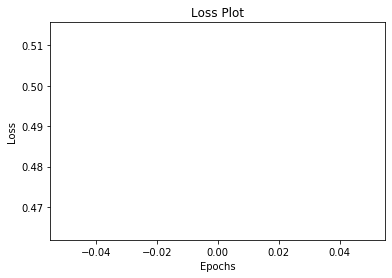

In [31]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()


In [32]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot


In [33]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()


73257
E:\Python\Img_Caption/train2014/COCO_train2014_000000162213.jpg
Real Caption: <start> a peeled onion and sliced carrots on a cutting board <end>
Prediction Caption: fresh fruit is along with a lemon shown have oranges carrots and chopped <end>


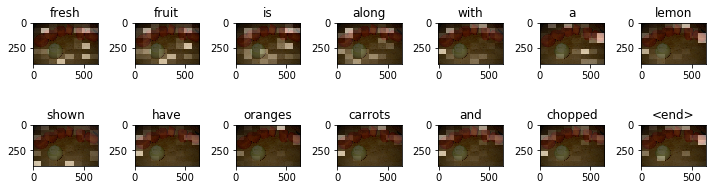

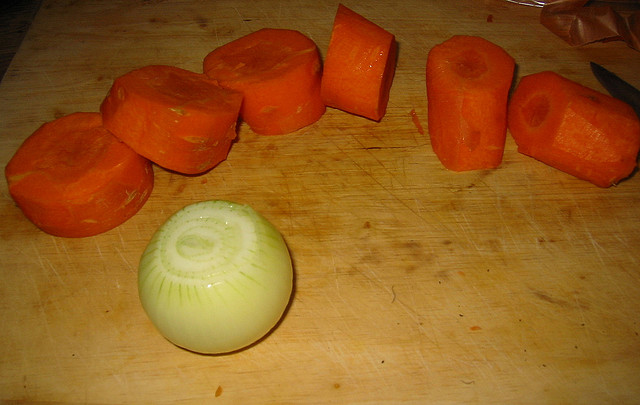

In [34]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
print(rid)
image = img_name_val[rid]
print(image)
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

Image.open(image)

Prediction Caption: a woman holding a great view looking off <end>


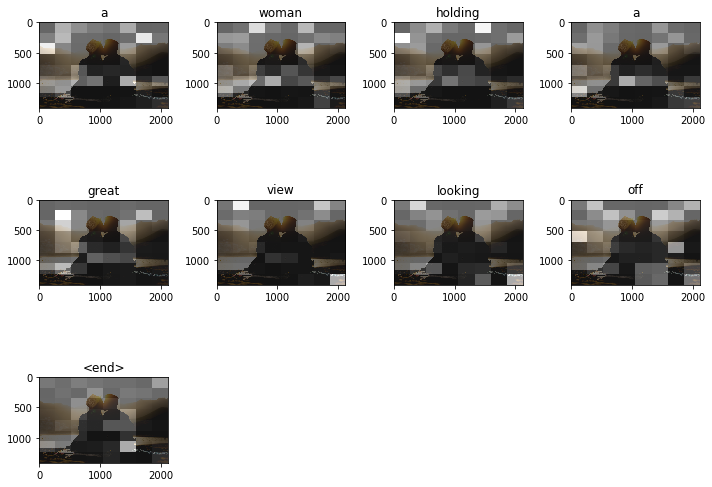

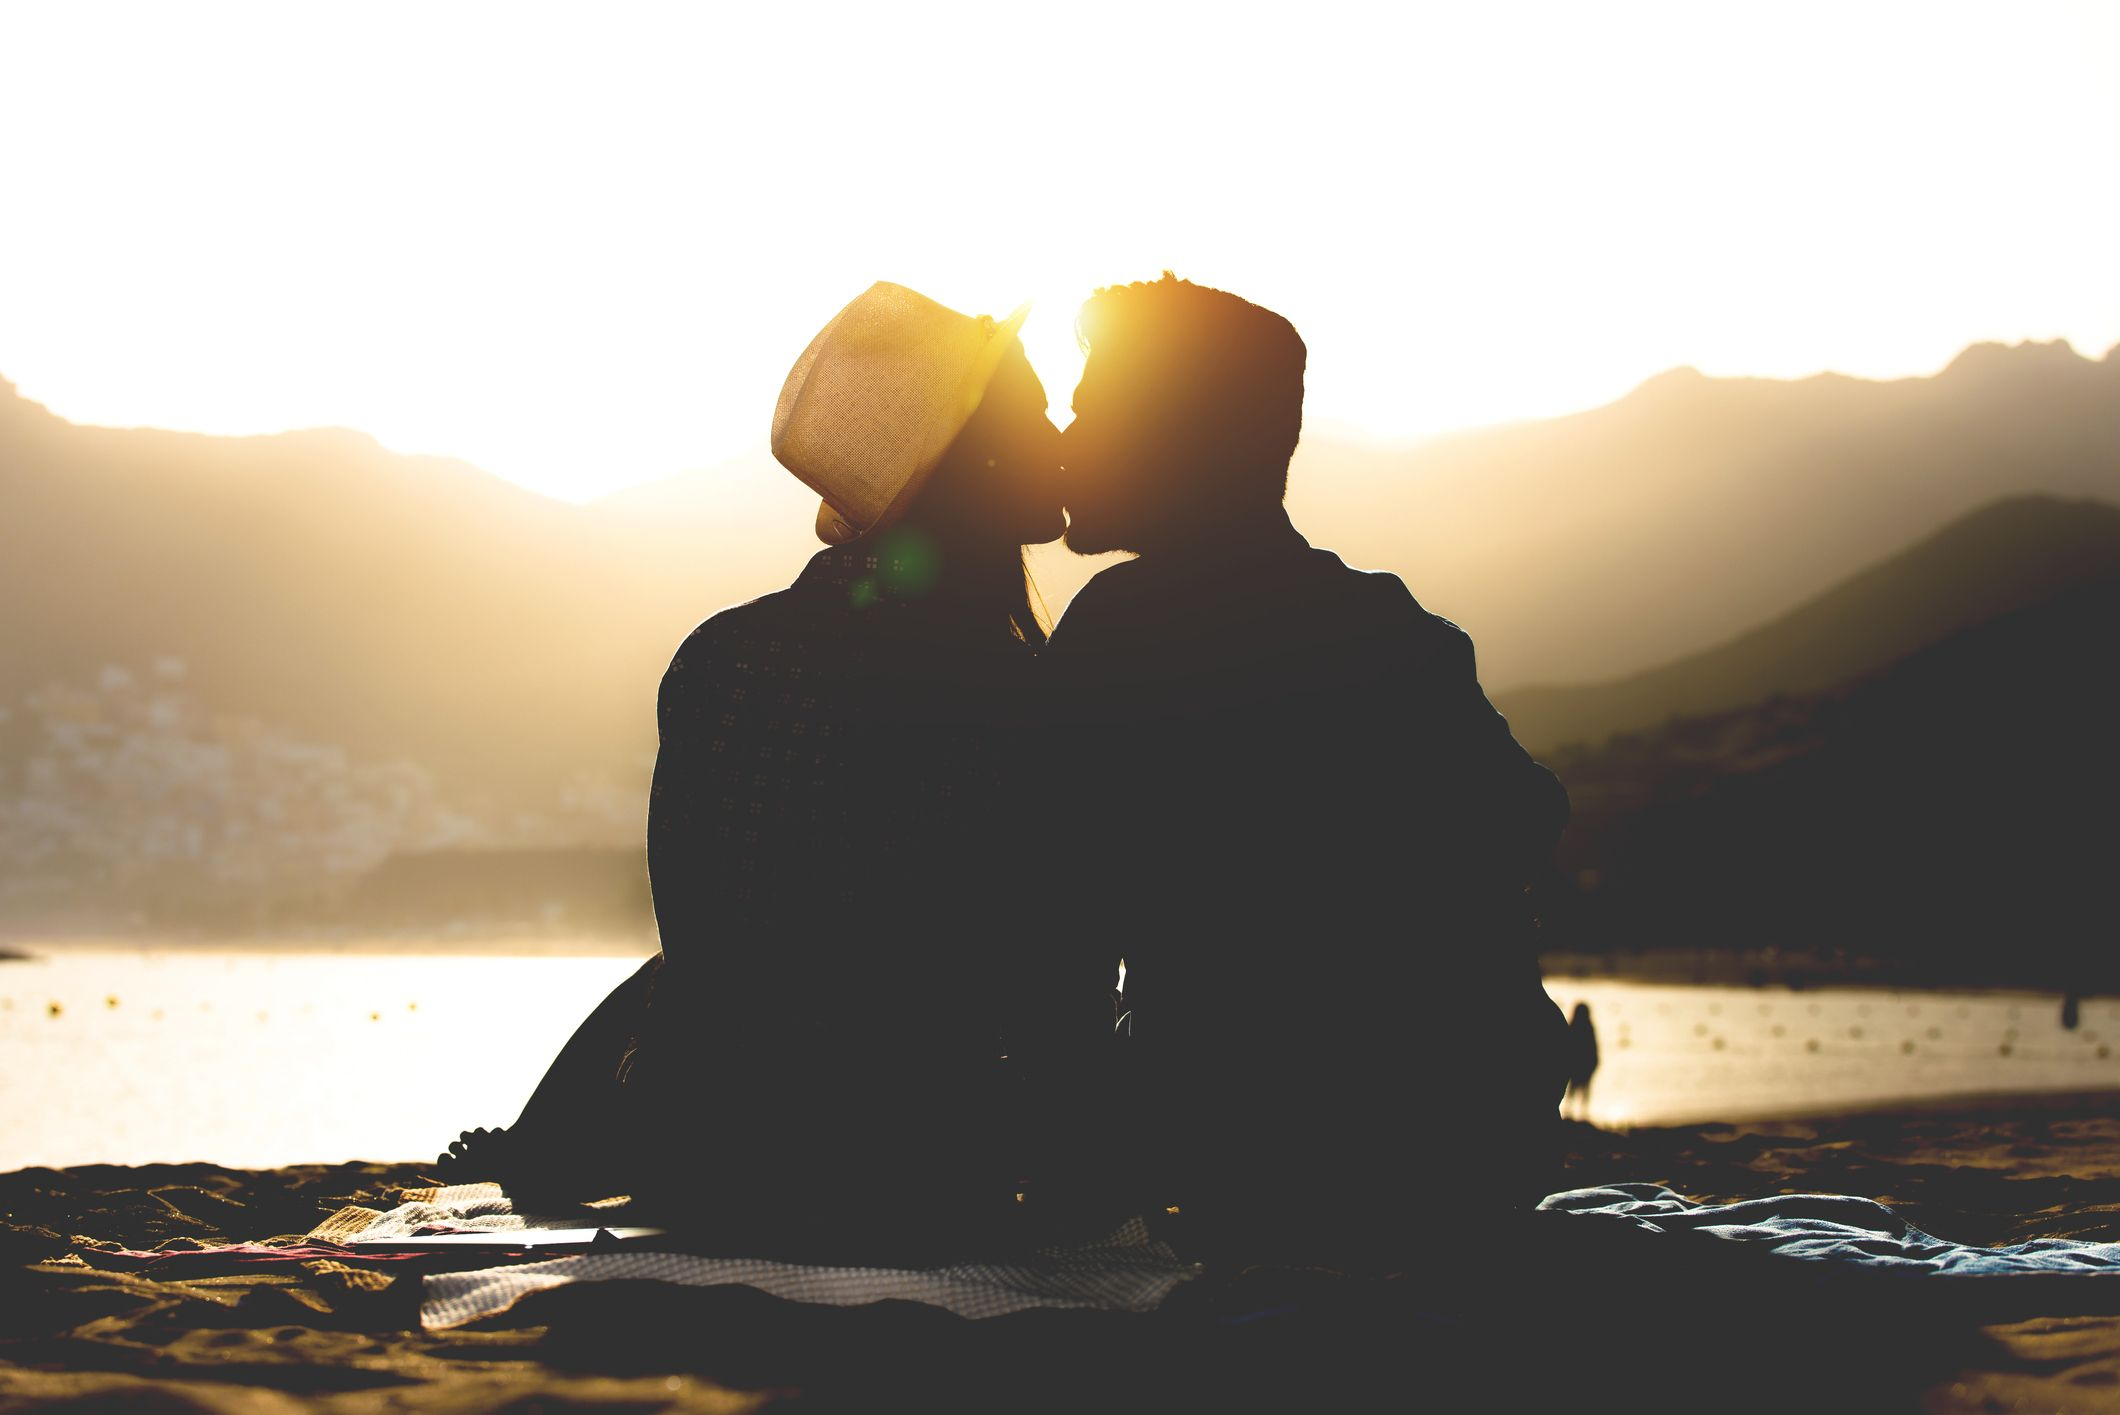

In [35]:
import requests
# TESTING PURPOSES
from pathlib import Path
curDir = os.getcwd()
Path(curDir + "/test/").mkdir(parents=True, exist_ok=True)
image_path = curDir+'/test/image.jpg'
image_url = "https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/instagram-captions-for-couples-1578955100.jpg"
with open(image_path, 'wb') as f:
    f.write(requests.get(image_url).content)



result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)